In [1]:
import os
import json
import math

import sys
sys.path.append("../utils")
from minimal_image import get_compact

from skimage.io import MultiImage

import matplotlib.pyplot as plt

import numpy as np

import cv2 as cv

from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [2]:
with open("../input/compact_representation.json", "r") as file:
    compact_representation = json.load(file)

In [3]:
data_dir = "../input/prostate-cancer-grade-assessment/train_images/"

In [4]:
# class Data(Dataset):
#     def __init__(self):
#         self.keys = list(compact_representation.keys())
    
#     def __len__(self):
#         return len(compact_representation)
    
#     def __getitem__(self, item):
#         key = self.keys[item]
#         item = compact_representation[key]
        
#         img = MultiImage(os.path.join(data_dir, key))[1]
#         compact = get_compact(img, item)
        
#         return img.shape, compact.shape

In [5]:
# loader = DataLoader(Data(), batch_size=1, num_workers=0)

# orig_shapes = []
# compact_shapes = []

# for orig, comp in tqdm(loader):
#     orig_shapes.append(orig)
#     compact_shapes.append(comp)

In [6]:
# import torch

In [7]:
# torch.stack(orig_shapes)

In [8]:
# orig_shapes = torch.cat([torch.stack(i, -1) for i in orig_shapes])


In [9]:
# compact_shapes = torch.cat([torch.stack(i, -1) for i in compact_shapes])

In [10]:
# orig_shapes.shape, compact_shapes.shape

In [11]:
# orig_shapes = orig_shapes.numpy()
# compact_shapes = compact_shapes.numpy()

In [12]:
import pandas as pd

In [13]:
# df = pd.DataFrame({
#     "names": list(compact_representation.keys()),
#     "h": orig_shapes[:, 0],
#     "w": orig_shapes[:, 1],
#     "comp_h": compact_shapes[:, 0],
#     "comp_w": compact_shapes[:, 1],
# })

In [14]:
# df

In [15]:
# df.to_csv("shapes.csv", index=False)

In [16]:
df = pd.read_csv("shapes.csv")
df

,names,h,w,comp_h,comp_w
0,2f305c85a7bb5ce4ea89ceee84f17f6b.tiff,7568,5727,775,6276
1,5d3dfae104348251b8fbc99f8d39a601.tiff,3008,960,896,2944
2,89f418346fc412a6458aaa05a224af3a.tiff,3392,2112,1858,3509
3,b53d843700d9665439ec8791e4024d70.tiff,2752,3072,1447,3748
4,0005f7aaab2800f6170c399693a96917.tiff,7360,6912,1313,5382
...,...,...,...,...,...
10611,ffd2841373b39792ab0c84cccd066e31.tiff,8192,2944,2900,6992
10612,ffdc59cd580a1468eac0e6a32dd1ff2d.tiff,1280,3584,878,3572
10613,ffe06afd66a93258f8fabdef6044e181.tiff,7168,2496,1988,7407
10614,ffe236a25d4cbed59438220799920749.tiff,2688,6656,1224,6988


In [17]:
df['h'] = df['h'] / 4
df['w'] = df['w'] / 4
df['comp_h'] = df['comp_h'] / 4
df['comp_w'] = df['comp_w'] / 4

In [18]:
import seaborn as sns

In [19]:
[df['h'].max(), df['comp_h'].max()], [df['h'].min(), df['comp_h'].min()]

([3456.0, 2055.25], [112.0, 0.0])

In [20]:
(df['h'] + df['w']).argmax()

10314

In [21]:
df.iloc[10314]

names     f948e5f2b0a49af2c0a7f3f74093262e.tiff
h                                          3424
w                                          6144
comp_h                                   997.25
comp_w                                  1337.25
Name: 10314, dtype: object

In [22]:
# img = MultiImage(os.path.join(data_dir, "f948e5f2b0a49af2c0a7f3f74093262e.tiff"))[0]

In [23]:
# img.sum(axis=1).shape

In [24]:
# img.shape

In [25]:
img1 = MultiImage(os.path.join(data_dir, "f948e5f2b0a49af2c0a7f3f74093262e.tiff"))[-1]

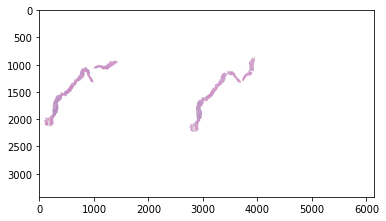

In [26]:
plt.imshow(img1)

In [27]:
# img1 = MultiImage(os.path.join(data_dir, "f948e5f2b0a49af2c0a7f3f74093262e.tiff"))[-1]
# cond = (255 - img1).sum(axis=(1, 2)) > 0
# img1 = img1[cond]
# cond = np.array([[i] * 16 for i in cond]).ravel()
# img = img[cond]

# cond = (255 - img1).sum(axis=(0, 2)) > 0
# img1 = img1[:, cond]
# cond = np.array([[i] * 16 for i in cond]).ravel()
# img = img[:, cond]

# plt.imshow(img1)

In [28]:
def find_boxes(image, preprocessed=False):
    if not preprocessed:
        if image.ndim > 2:
            image = cv.cvtColor(image, cv.COLOR_RGB2GRAY)
        image = (image != 255).astype(np.uint8)
        image = cv.morphologyEx(image, cv.MORPH_CLOSE, cv.getStructuringElement(cv.MORPH_RECT, (10, 10)))
    countours, hierarchy = cv.findContours(image, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    
    min_rects = []
    for c in countours:
        rect = cv.boundingRect(c)
        min_rects.append(rect)
    
    return [[x, y, x + w, y + h] for x, y, w, h in min_rects]

In [29]:
def moving_sum(a, n=3) :
    ret = np.cumsum(a)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:]

In [30]:
def find_tile_boxes(img, sz=64, threshold=0, max_overlap=0.0):
    if img.ndim == 3 and img.shape[-1] == 3:
        img = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    img = 255 - img
    
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz
    img = cv.copyMakeBorder(img,
                            top=0, left=sz,
                            bottom=pad0 + sz, right=pad1 + sz,
                            borderType=cv.BORDER_CONSTANT, value=0)
    
    msum = moving_sum(img, sz)
    
    sums = []
    bboxes = []
    for i in  range(0, img.shape[0], sz):
        y1 = i
        y2 = i + sz
        
        sub_img = img[y1:y2]
        m_sum = moving_sum(sub_img.sum(axis=0), sz)
        
        indexes = np.argsort(m_sum)
        
        cond = m_sum[indexes] > threshold
        indexes = indexes[cond]
        
        while len(indexes):
            x1 = indexes[-1]
            x2 = x1 + sz
            cond1 = indexes > (x1 - int(sz * (1 - max_overlap)))
            cond2 = indexes <= (x2 - int(sz * max_overlap))
            indexes = indexes[~(cond1 & cond2)]
            
            sums.append(int(m_sum[x1]))
            
            x1 -= sz
            x2 = x2 - sz
            bboxes.append([x1, y1, x2, y2])
    return np.array(bboxes), np.array(sums)

In [31]:
def _tile(img, sz=256, N=100):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
                 constant_values=255)
    
    shape = img.shape

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    num = len(img)

    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]

    img = img[idxs]
    s = int(np.sqrt(N))

    indexes = np.arange(N)

    boxes = []
    for i, j in enumerate(indexes):
        if i >= len(img):
            break
        if i >= num:
            break
        
        x = idxs[i] % (shape[1] // sz)
        y = idxs[i] // (shape[1] // sz)
        x1 = x * sz
        x2 = (x + 1) * sz
        y1 = y * sz
        y2 = (y + 1) * sz
        x1 -= pad1
        x2 -= pad1
        y1 -= pad0
        y2 -= pad0
        boxes.append([x1, y1, x2, y2])


    return np.array(boxes)

In [32]:
def get_new_tile_boxes(img, size):
    h, w = img.shape[:2]

    boxes = find_boxes(img)

    tile_boxes = []
    tile_sums = []
    for i, box in enumerate(boxes):
        sub_img = img[box[1]:box[3], box[0]:box[2]]

        b, s = find_tile_boxes(sub_img, size, max_overlap=0.0)
        b = b.astype(np.float32)
        b[:, 0::2] = (b[:, 0::2] + box[0]) / w
        b[:, 1::2] = (b[:, 1::2] + box[1]) / h
        tile_boxes.append(b)
        tile_sums.append(s)

    tile_sums = np.concatenate(tile_sums)
    tile_boxes = np.concatenate(tile_boxes)

    return tile_boxes, tile_sums

71


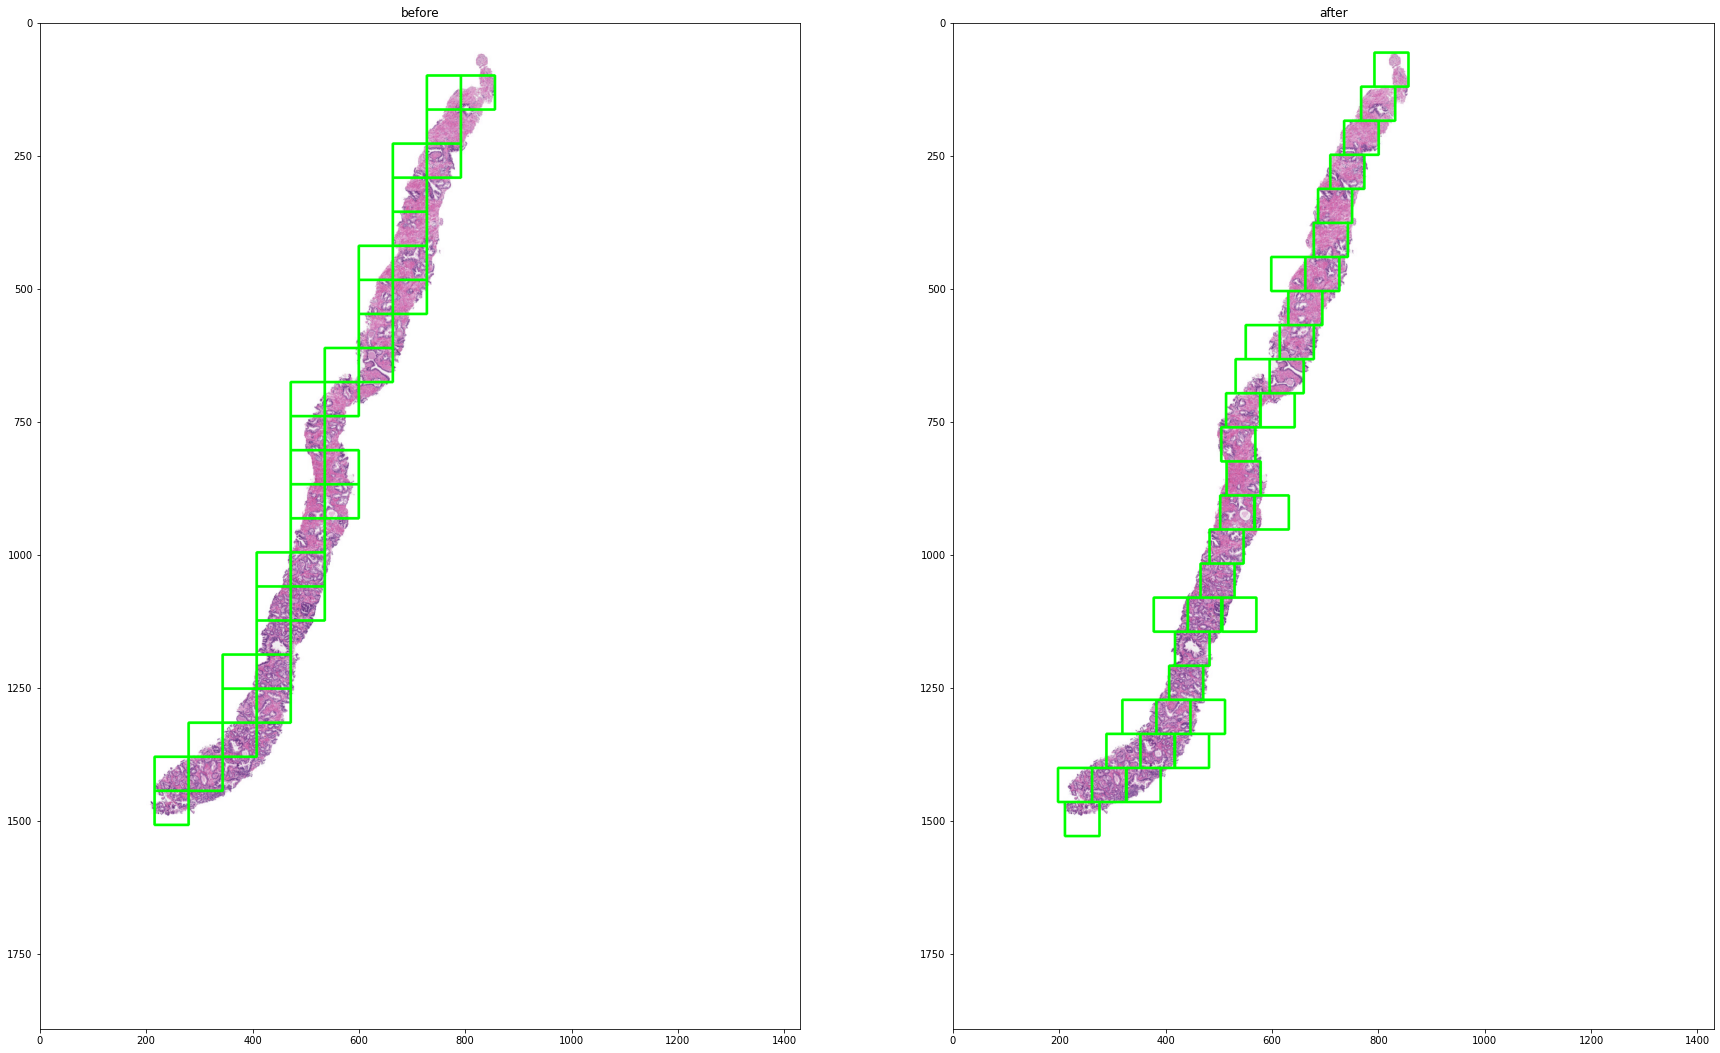

In [35]:
idx = 0
sz = 64
size = sz

img = MultiImage(os.path.join(data_dir, df['names'].iloc[idx]))[-1]
h, w = img.shape[:2]

tmp = img.copy()

for box in _tile(img, sz, 36):
    cv.rectangle(tmp, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 3)
plt.figure(figsize=(30, 30))
plt.subplot(121, title="before")
plt.imshow(tmp)
    
# boxes = find_boxes(img)
# tile_boxes = []
# tile_sums = []
# for i, box in enumerate(boxes): 
#     sub_img = img[box[1]:box[3], box[0]:box[2]]
    
#     b, s = find_tile_boxes(sub_img, sz, max_overlap=0.0)
#     b = b.astype(np.float32)
#     b[:, 0::2] = (b[:, 0::2] + box[0]) / w
#     b[:, 1::2] = (b[:, 1::2] + box[1]) / h
#     tile_boxes.append(b)
#     tile_sums.append(s)

# tile_sums = np.concatenate(tile_sums)
# tile_boxes = np.concatenate(tile_boxes)

tile_boxes, tile_sums = get_new_tile_boxes(img, size)

# tmp = MultiImage(os.path.join(data_dir, df['names'].iloc[idx]))[1]
tmp = img.copy()
h, w = tmp.shape[:2]
print(len(tile_boxes))
for box in tile_boxes[np.argsort(tile_sums)[::-1]][:36]:
    box = box.copy()
    box[0::2] *= w
    box[1::2] *= h
    box = box.astype(int)
    cv.rectangle(tmp, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 3)

# plt.figure(figsize=(30, 30))
plt.subplot(122, title="after")
plt.imshow(tmp);

In [84]:
def get_tiles_new(img, boxes, sums, size=64, num=36, pad_value=(255, 255, 255), random=False):
    h, w = img.shape[:2]
    
    s = int(np.sqrt(num))
    result = np.full([s * size, s * size, 3], pad_value, dtype=img.dtype)
    
    if random:
        np.random.shuffle(boxes)
        boxes = boxes[:num]
    else:
        boxes = boxes[np.argsort(sums)[::-1]][:num]
    for i, box in enumerate(boxes):
        x = i % s
        y = i // s
        
        box = box.copy()
        box[0::2] *= w
        box[1::2] *= h
        x1, y1, x2, y2 = box.astype(int)
        
        tile = img[y1:y2, x1:x2]
        th, tw = tile.shape[:2]
        if th > size or tw > size:
            tile = tile[:size, :size]
        if th < size or tw < size:
            th, tw = tile.shape[:2]
            pad_h = size - th
            pad_w = size - tw
            tile = cv.copyMakeBorder(tile, top=0, left=0, bottom=pad_h, right=pad_w,
                                     borderType=cv.BORDER_CONSTANT, value=pad_value)
        
        result[y * size:(y + 1) * size, x * size:(x + 1) * size] = tile
    
    return result

In [85]:
def tile(img, sz=128, N=16, transform=None, random=False):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
                 constant_values=255)

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)

    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]

    img = img[idxs]
    s = int(np.sqrt(N))
    result = np.full([sz * s, sz * s, 3], 255, dtype=np.uint8)

    indexes = np.arange(N)
    if random:
        np.random.shuffle(indexes)

    for i, j in enumerate(indexes):
        if i >= len(img):
            break
        x = j % s
        y = j // s
        img_i = img[i] if transform is None else transform(image=img[i])["image"]
        if result.dtype != img_i.dtype:
            result = result.astype(img_i.dtype)
        result[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img_i

    return result

47


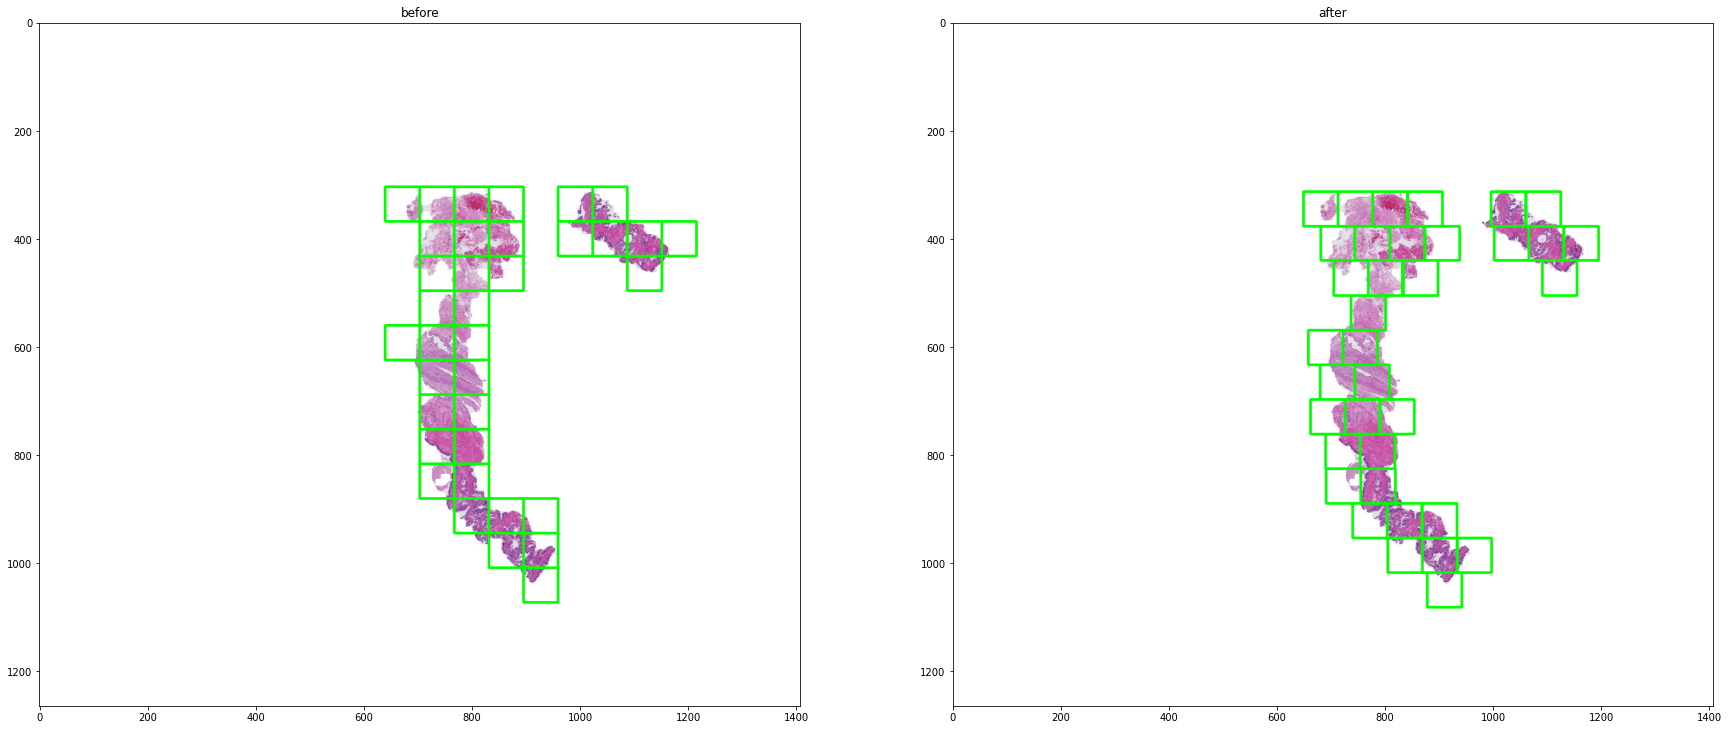

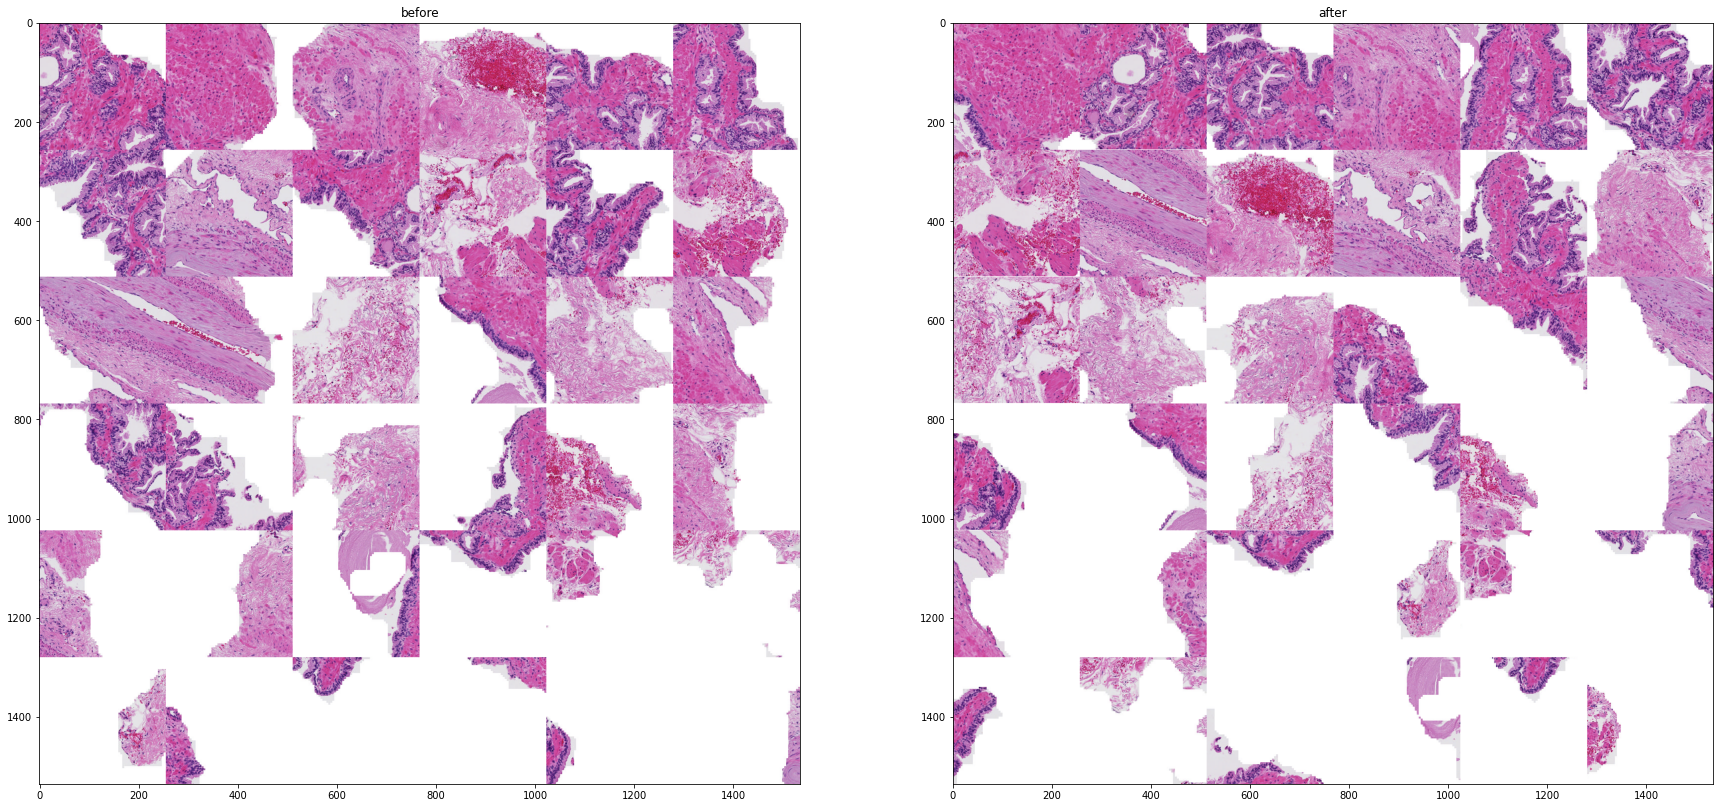

In [92]:
idx = 10500
size = 256
sz = size
N = 36

img = MultiImage(os.path.join(data_dir, df['names'].iloc[idx]))[1]
img_low = MultiImage(os.path.join(data_dir, df['names'].iloc[idx]))[-1]

tmp = img_low.copy()
for box in _tile(tmp, sz // 4, N):
    cv.rectangle(tmp, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 3)
plt.figure(figsize=(30, 30))
plt.subplot(121, title="before")
plt.imshow(tmp)

# 
boxes = find_boxes(img_low)
tile_boxes, tile_sums = get_new_tile_boxes(img_low, size // 4)
print(len(tile_boxes))
tmp = img_low.copy()
h, w = tmp.shape[:2]
for box in tile_boxes[np.argsort(tile_sums)[::-1]][:36]:
    box = box.copy()
    box[0::2] *= w
    box[1::2] *= h
    box = box.astype(int)
    cv.rectangle(tmp, tuple(box[:2]), tuple(box[2:]), (0, 255, 0), 3)

# plt.figure(figsize=(30, 30))
plt.subplot(122, title="after")
plt.imshow(tmp);

tile1 = tile(img, size, N=N)
tile2 = get_tiles_new(img, *get_new_tile_boxes(img_low, size // 4), size=size, num=N)

plt.figure(figsize=(30, 30))
plt.subplot(121, title="before")
plt.imshow(tile1)
plt.subplot(122, title="after")
plt.imshow(tile2);

In [ ]:
[df['w'].max(), df['comp_w'].max()], [df['w'].min(), df['comp_w'].min()]

In [ ]:
masks_dir = "../input/prostate-cancer-grade-assessment/train_label_masks"

In [ ]:
df['comp_w'].argmax()

In [ ]:
import cv2 as cv

In [ ]:
def tile(img, sz=256, N=100):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
                 constant_values=255)
    
    result = img
    shape = img.shape

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    num = len(img)

    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)
def tile(img, sz=256, N=100):
    shape = img.shape
    pad0, pad1 = (sz - shape[0] % sz) % sz, (sz - shape[1] % sz) % sz

    img = np.pad(img, [[pad0 // 2, pad0 - pad0 // 2], [pad1 // 2, pad1 - pad1 // 2], [0, 0]],
                 constant_values=255)
    
    result = img
    shape = img.shape

    img = img.reshape(img.shape[0] // sz, sz, img.shape[1] // sz, sz, 3)
    img = img.transpose(0, 2, 1, 3, 4).reshape(-1, sz, sz, 3)
    
    num = len(img)

    if len(img) < N:
        img = np.pad(img, [[0, N - len(img)], [0, 0], [0, 0], [0, 0]], constant_values=255)

    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]

    img = img[idxs]
    s = int(np.sqrt(N))
    r = np.full([sz * s, sz * s, 3], 255, dtype=np.uint8)

    indexes = np.arange(N)

    for i, j in enumerate(indexes):
        if i >= len(img):
            break
        if i >= num:
            break
            
        x = j % s
        y = j // s
        img_i = img[i]
        if r.dtype != img_i.dtype:
            result = result.astype(img_i.dtype)
        r[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img_i
        
        x = idxs[i] % (shape[1] // sz)
        y = idxs[i] // (shape[1] // sz)
        x1 = x * sz
        x2 = (x + 1) * sz
        y1 = y * sz
        y2 = (y + 1) * sz
        cv.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)


    return result, r
    idxs = np.argsort(img.reshape(img.shape[0], -1).sum(-1))[:N]

    img = img[idxs]
    s = int(np.sqrt(N))
    r = np.full([sz * s, sz * s, 3], 255, dtype=np.uint8)

    indexes = np.arange(N)

    for i, j in enumerate(indexes):
        if i >= len(img):
            break
        if i >= num:
            break
            
        x = j % s
        y = j // s
        img_i = img[i]
        if r.dtype != img_i.dtype:
            result = result.astype(img_i.dtype)
        r[y * sz:(y + 1) * sz, x * sz:(x + 1) * sz] = img_i
        
        x = idxs[i] % (shape[1] // sz)
        y = idxs[i] // (shape[1] // sz)
        x1 = x * sz
        x2 = (x + 1) * sz
        y1 = y * sz
        y2 = (y + 1) * sz
        cv.rectangle(result, (x1, y1), (x2, y2), (0, 255, 0), 2)


    return result, r

In [ ]:
(df["comp_h"] * df['comp_w']).argmax()

In [ ]:
idx = 0
index = 6831

for key, item in compact_representation.items():
    key = df.iloc[index]["names"]
    item = compact_representation[key]
    img = MultiImage(os.path.join(data_dir, key))[idx]
#     mask = MultiImage(os.path.join(masks_dir, os.path.splitext(key)[0] + "_mask.tiff"))[idx]
#     img = get_compact(img, item)
    img, img_tile = tile(img)
#     mask = get_compact(mask, item, default_val=0)
    
    break

plt.figure(figsize=(30, 15))
# plt.subplot(211)
plt.imshow(img)
# plt.subplot(212)
# plt.imshow(img_tile)
# plt.subplot(212)
# plt.imshow((mask > 1) * 255);

In [ ]:
np.unique(mask)

In [ ]:
df_train = pd.read_csv("../input/prostate-cancer-grade-assessment/train.csv")

In [ ]:
df_train[df_train['image_id'] == key.replace(".tiff", "")]

In [ ]:
mask.max()

In [ ]:
df_train.groupby("data_provider").count()